In [1]:
import sys
import importlib
from os import path
# Add a directory to the search path
sys.path.append('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI')
from utils.utils import (
    preprocess_traces,
    find_max_trace_length,
    read_segy_file,
    visualize_seismic_data,
    train_contrastive_ts,
    segment_into_sequences,
    create_patches,
    scale_subsequences,
    reshape_into_subsequences,
    generate_test_pairs,
    plot_aline
)
from utils.metrics import (
    pixelwise_accuracy,
    class_accuracy,
    mean_class_accuracy,
    mean_iou,
)
from utils.augmentations import (
    DataAugmentation,
    Compose,
    AddNoise,
    RandomCrop,
    CenterCrop,
    RandomHorizontallyFlip,
    RandomVerticallyFlip,
    FreeScale,Scale,
    RandomSizedCrop,
    RandomRotate,
    RandomSized
)

from utils.patch import PatchLoader
from data.preprocess import TimeSeriesTFRecordReader,ImageMaskTFRecordWriter,TimeSeriesTFRecordWriter,TFRecordReader,TFRecordWriter
from models.contrastive_learning import ContrastiveTimeSeriesModel, TimeSeriesAugmentation, Contrastive1DCNNModel
from models.contrastive_learning import generate_pairs, contrastive_loss, augment_time_series
from models.CNNs import UNet, ResNetSegmentation
import numpy as np
import tensorflow as tf
import pandas as pd
import keras as ks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Print all directories Python will search for modules
# import sys
# for path in sys.path:
#     print(path)


TypeError: UNet.__init__() missing 1 required positional argument: 'filters'

In [2]:
# Load training data and labels
# train_seismic = np.load(path.join(config.DATASET.ROOT, "train/train_seismic.npy"))
# train_labels = np.load(path.join(config.DATASET.ROOT, "train/train_labels.npy"))

train_labels = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/train/train_labels.npy')
train_seismic = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/train/train_seismic.npy')

print(f"Number of inline slices: {train_seismic.shape[0]}")
print(f"Number of crossline slices: {train_seismic.shape[1]}")
print(f"Depth dimension : {train_seismic.shape[2]}")

Number of inline slices: 401
Number of crossline slices: 701
Depth dimension : 255


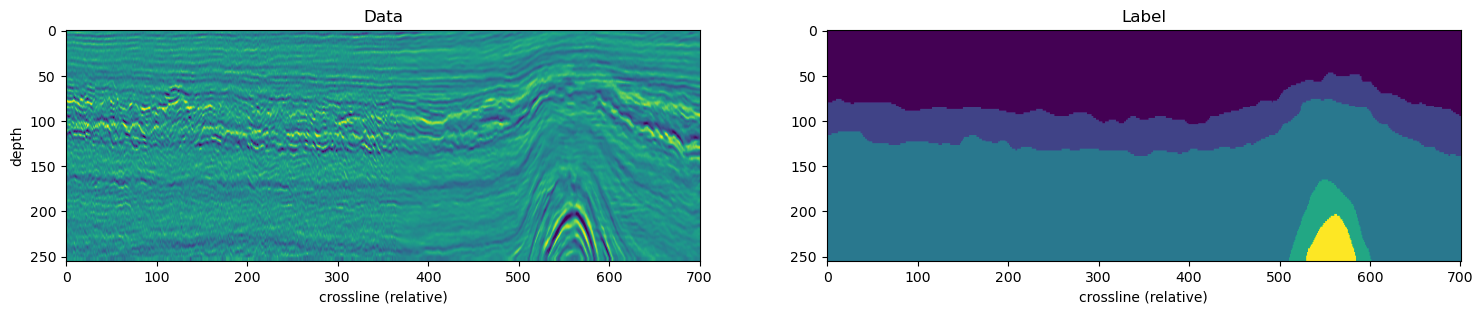

In [6]:
idx = 400
x_in = train_seismic[idx, :, :].swapaxes(0, 1)
x_inl = train_labels[idx, :, :].swapaxes(0, 1)

plot_aline(x_in, x_inl, xlabel="crossline (relative)")

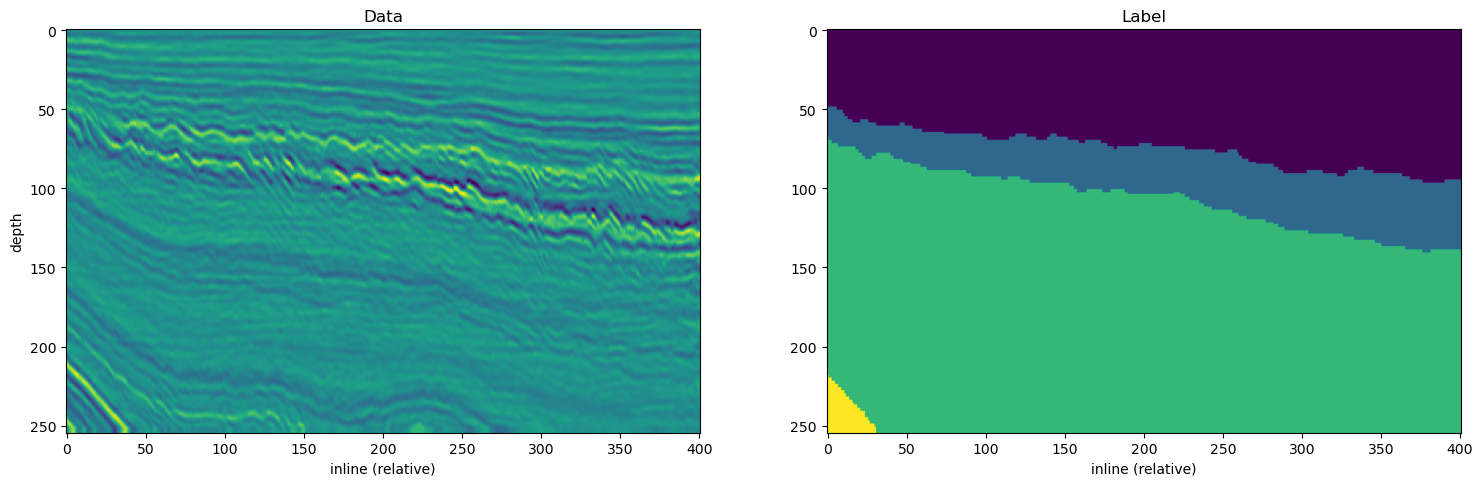

In [10]:
idx = 700
x_cr = train_seismic[:, idx, :].swapaxes(0, 1)
x_crl = train_labels[:, idx, :].swapaxes(0, 1)

plot_aline(x_cr, x_crl, xlabel="inline (relative)")

# figure out how to turn it into the below datasets.

In [3]:
train_seismic.shape

NameError: name 'train_seismic' is not defined

In [ ]:
input_shape = (256, 256, 3)
num_classes = 5
filters = [64, 128, 256, 512]  # Example: Adding more layers is as simple as extending this list

model = UNet(input_shape=input_shape, num_classes=num_classes, filters=filters)

train, val, test = model.prepare_data(data, labels, test_size=0.2, val_size=0.25)

model.summary()

In [ ]:
# Example usage
augmentations = [RandomHorizontallyFlip(),
                 RandomSized(), 
                 RandomVerticallyFlip(),
                 FreeScale(),
                 Scale(),
                 RandomSizedCrop(),
                 RandomRotate(),
                 AddNoise(),
                 RandomCrop(),
                 CenterCrop()
                 ]  # Define more augmentations as needed
augmenter = DataAugmentation(augmentations)
image_paths = ['path_to_image1.npy', 'path_to_image2.npy']  # Paths to your image data files
mask_paths = ['path_to_mask1.npy', 'path_to_mask2.npy']  # Paths to your mask data files
patch_loader = PatchLoader(image_paths, mask_paths, patch_size=(128, 128), batch_size=16, augment=augmenter)

# Accessing the dataset
dataset = patch_loader.dataset
for images, masks in dataset.take(1):
    print(images.shape, masks.shape)  # Check the shapes

In [1]:
##################
# Metrics
#################


num_classes = 5  # Adjust based on number of classes

# Initialize metrics
pixel_accuracy = pixelwise_accuracy(num_classes)
class_acc = class_accuracy(num_classes)
mean_cls_acc = mean_class_accuracy(num_classes)
m_iou = mean_iou(num_classes)

NameError: name 'pixelwise_accuracy' is not defined

In [ ]:
# Assuming 'test_dataset' is prepared and ready
evaluation_results = evaluate_model(test_dataset)


In [ ]:
# run training

model = create_model((128, 128, 1), num_classes=4)
train(train_dataset, epochs=10)

results = model.evaluate(test_dataset)
print("Test results - Loss: {:.4f}, Accuracy: {:.4f}".format(results[0], results[1]))

In [ ]:
# Setup Augmentations
base_aug = Compose(
    [
        Normalize(
            mean=(config.TRAIN.MEAN,), std=(config.TRAIN.STD,), max_pixel_value=1
        ),
        PadIfNeeded(
            min_height=config.TRAIN.PATCH_SIZE,
            min_width=config.TRAIN.PATCH_SIZE,
            border_mode=0,
            always_apply=True,
            mask_value=255,
            value=0,
        ),
        Resize(
            config.TRAIN.AUGMENTATIONS.RESIZE.HEIGHT,
            config.TRAIN.AUGMENTATIONS.RESIZE.WIDTH,
            always_apply=True,
        ),
        PadIfNeeded(
            min_height=config.TRAIN.AUGMENTATIONS.PAD.HEIGHT,
            min_width=config.TRAIN.AUGMENTATIONS.PAD.WIDTH,
            border_mode=config.OPENCV_BORDER_CONSTANT,
            always_apply=True,
            mask_value=255,
        ),
    ]
)

if config.TRAIN.AUGMENTATION:
    train_aug = Compose([base_aug, HorizontalFlip(p=0.5)])
    val_aug = base_aug
else:
    raise NotImplementedError(
        "We don't support turning off data augmentation at this time"
    )

In [2]:
print(tf.__version__)
# check to make sure 2.16 is installed


2.16.1


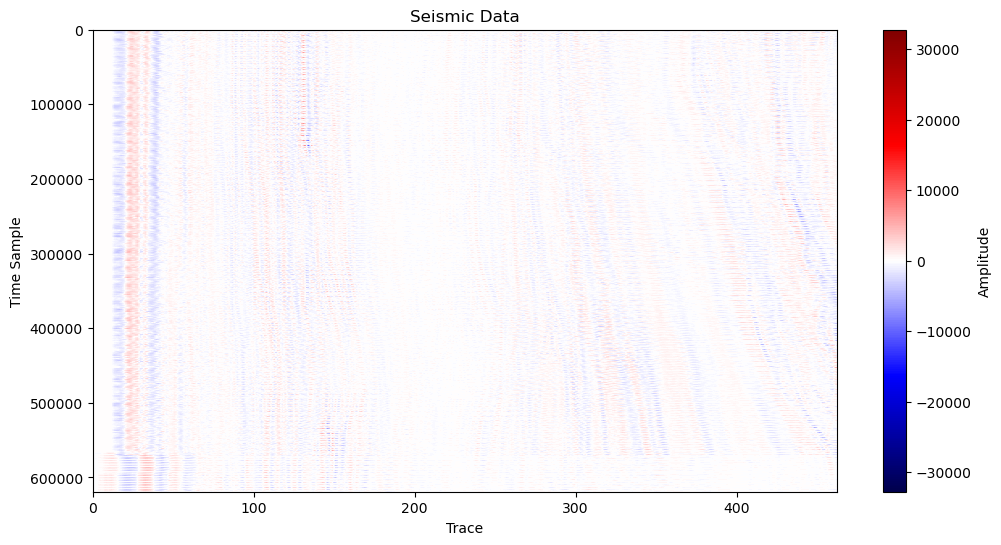

In [3]:
###########
# Test
###########    
file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/F3_entire.segy'
seismic_data = read_segy_file(file_path)
#visualize_seismic_data(seismic_data)

max_length=find_max_trace_length(file_path)
data=preprocess_traces(file_path, max_length, padding_value=0)
#visualize_seismic_data(data)


In [5]:
sequence_length = 128
step_size = 128  # To create non-overlapping sequences

# Segment the dataset
sequences = segment_into_sequences(data, sequence_length, step_size)
print(f"Generated sequences shape: {sequences.shape}")
# num_sequences, sequence_length, num_features

Generated sequences shape: (4836, 128, 462)


In [6]:
sequence_length = 128  # Example choice; you'll segment your data into sequences of this length
num_features = 462  # Based on your dataset's structure
feature_dim = 64  # Example choice for the size of the embedding vector

# Initialize the model
model = ContrastiveTimeSeriesModel(input_shape=(sequence_length, num_features), feature_dim=feature_dim)


In [ ]:
num_positive_pairs = 100000  # Example quantity
num_negative_pairs = 100000  # Example quantity

model = ContrastiveTimeSeriesModel(input_shape=(128, 462), feature_dim=64)  # Example model initialization
pairs, labels = model.generate_pairs(data, num_positive_pairs, num_negative_pairs)

# Now `pairs` contains your generated positive and negative pairs,
# and `labels` contains the corresponding labels indicating whether a pair is positive or negative.

In [2]:
##################
# Training routine
##################

###############
# reading data
###############    
file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/F3_entire.segy'
seismic_data = read_segy_file(file_path)
#visualize_seismic_data(seismic_data)

#################
# preprocess data
#################
max_length=find_max_trace_length(file_path)
data=preprocess_traces(file_path, max_length, padding_value=0)
#visualize_seismic_data(data)

####################
# subsequence length
####################
sequence_length = 128
step_size = 128  # To create non-overlapping sequences

# Reshape the data into subsequences
subsequences = reshape_into_subsequences(data, sequence_length, step_size)
#sequences = segment_into_sequences(data, sequence_length, step_size)
print(f"Generated sequences shape: {subsequences.shape}")

################
# create patches
################
# Create patches from data
# patch_size = 500  # Length of each patch
# step = 500  # Step size between patches
# patches = create_patches(data, patch_size, step)

# Scale the subsequences
#subsequences_scaled, scaler = scale_subsequences(sequences)

#############
# Split data
#############

# Lets change this. We want to train on the whole dataset, then test on the whole dataset without augmented pairs.
# after we do this, 
X_train_val, X_test = train_test_split(subsequences, test_size=0.15, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.15, random_state=42)  

#############
# Scale data
#############
# scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_val_scaled = scaler.transform(X_val)
# # X_test_scaled = scaler.transform(X_test)
# train_patches = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# val_patches = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
# test_patches = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

#############################
# Generate pairs for training
#############################
# Assuming your model and generate_pairs function are defined
pairs_train, labels_train = generate_pairs(X_train, num_pairs=100000, positive_ratio=0.5)
pairs_val, labels_val = generate_pairs(X_val, num_pairs=20000, positive_ratio=0.5)
pairs_test, labels_test = generate_test_pairs(X_test, num_pairs=10000)

Generated sequences shape: (4836, 128, 462)


In [3]:
pairs_train.shape

(100000, 2, 128, 462)

In [4]:
#############
# Train model 
#############
#(assuming model is instance of ContrastiveTimeSeriesModel or similar)
#model.train_model(tf.data.Dataset.from_tensor_slices((pairs_train, labels_train)), epochs=50)

# Assuming 'data' is your loaded and preprocessed seismic dataset
#pairs, labels = generate_pairs(data, num_pairs=1000, positive_ratio=0.5)


# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((pairs_train, labels_train)).batch(32).prefetch(tf.data.AUTOTUNE)

# Initialize and train the model
input_shape = (128, 462)  # Example input shape
feature_dim = 64  # Embedding size
model = Contrastive1DCNNModel(input_shape=input_shape, feature_dim=feature_dim)

model.summary()  # To see the detailed architecture of the model



: 

In [24]:
#############
# Train model 
#############

model.train_model(train_dataset, epochs=10)

Epoch 1/10


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0000e+00
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0000e+00
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0000e+00


In [6]:
embeddings = model.get_embeddings(model, train_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [21]:
embeddings_array = np.array(embeddings) 
#embeddings[1].shape
embeddings_array.shape

(2, 10000, 64)

In [27]:
#############
# Train model 
#############


# First Embedding (output_1): Represents the embedding of the first element of the input pair.
# Second Embedding (output_2): Represents the embedding of the second element of the input pair.

# Assuming embeddings is the array with shape (2, 10000, 64)
embeddings_1 = embeddings_array[0]  # First set of embeddings
embeddings_2 = embeddings_array[1]  # Second set of embeddings


# Cluster the embeddings using K-means
cluster_labels_kmeans_1 = model.cluster_embeddings(embeddings_1, method='kmeans', n_clusters=5)
cluster_labels_kmeans_2 = model.cluster_embeddings(embeddings_2, method='kmeans', n_clusters=5)


# Concatenate embeddings along the feature axis for joint clustering
combined_embeddings = np.concatenate((embeddings_1, embeddings_2), axis=1)  # shape becomes (10000, 128)
kmeans_combined = model.cluster_embeddings(combined_embeddings, method='kmeans', n_clusters=5)
# Or cluster the embeddings using hierarchical clustering
#cluster_labels_hierarchical = model.cluster_embeddings(embeddings, method='hierarchical', n_clusters=5, linkage_method='ward')

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# tsne = TSNE(n_components=2, random_state=42)
# test_embeddings_2d = tsne.fit_transform(cluster_labels_kmeans_1)

# plt.figure(figsize=(8, 6))
# plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5)
# plt.title('t-SNE plot of Test Embeddings')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.show()

# Visualize using t-SNE
#model.visualize_clusters(embeddings, cluster_labels_kmeans, method='tsne')

# Visualize using UMAP
#model.visualize_clusters(embeddings, cluster_labels_hierarchical, method='umap')

In [29]:
cluster_labels_kmeans_1

# Assuming 'cluster_labels' is a flat array where each label corresponds to a segment of a trace
# and you know the 'time_steps' used to segment each trace.
time_steps = 619101  # total number of time steps you mentioned initially
traces = 462  # total number of traces

# Example reshaping if you clustered on individual segments or full traces directly
cluster_labels_reshaped = cluster_labels_kmeans_1.reshape((time_steps, traces))

ValueError: cannot reshape array of size 10000 into shape (619101,462)

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(32)  # Adjust batch size as needed
test_embeddings = model.get_embeddings(model, test_dataset)

NameError: name 'generate_test_pairs' is not defined

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
test_embeddings_2d = tsne.fit_transform(test_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5)
plt.title('t-SNE plot of Test Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()